C:\Users\jvgat\AppData\Local\Temp\ipykernel_21612\4038364862.py:8: DtypeWarning: Columns (34,35,36,37,39,40,41,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/df_after_feature_engineering.csv")


Cross-listing count distribution:
count    127515.000000
mean          1.445155
std           0.497048
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: cross_listing_count, dtype: float64

CWE risk factor distribution:
count    127515.000000
mean          0.005289
std           0.009339
min           0.000000
25%           0.000576
50%           0.001830
75%           0.008772
max           1.000000
Name: cwe_risk_factor, dtype: float64

New strata distribution:
cross_listing_count_cat  cwe_risk_category
1                        low                  25843
                         medium                9964
                         high                 17315
                         critical             17633
2                        low                  21075
                         medium                7120
                         high                 14927
                         critical             13634
3 

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a


Model Summary:
                                 coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                    
base_score                   0.441677   1.555313  0.028961        0.384915   
repo_publication_lag_rank   -0.000010   0.999990  0.000002       -0.000015   
cross_listing_variance_sqrt -0.116441   0.890083  0.092807       -0.298340   

                             coef upper 95%  exp(coef) lower 95%  \
covariate                                                          
base_score                         0.498439             1.469490   
repo_publication_lag_rank         -0.000006             0.999985   
cross_listing_variance_sqrt        0.065459             0.742049   

                             exp(coef) upper 95%  cmp to          z  \
covariate                                                             
base_score                              1.646149     0.0  15.250960   
repo_publication_lag_rank              

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2744: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, _df in self._predicted_partial_hazards_.groupby(self.strata):



Concordance index: 0.6838588311371683


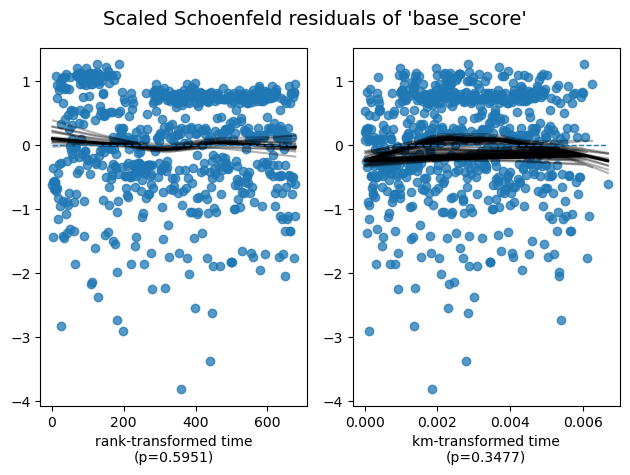

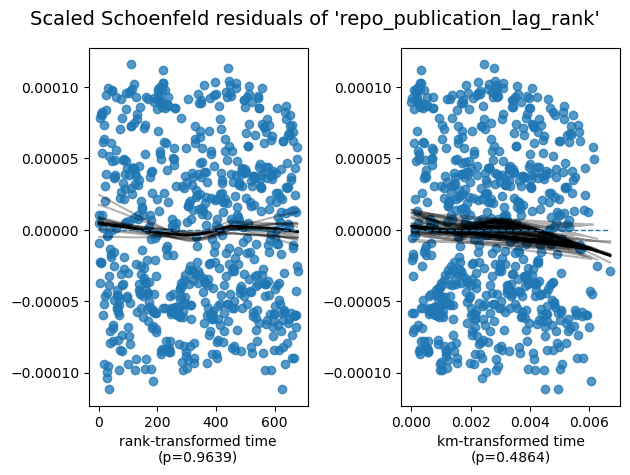

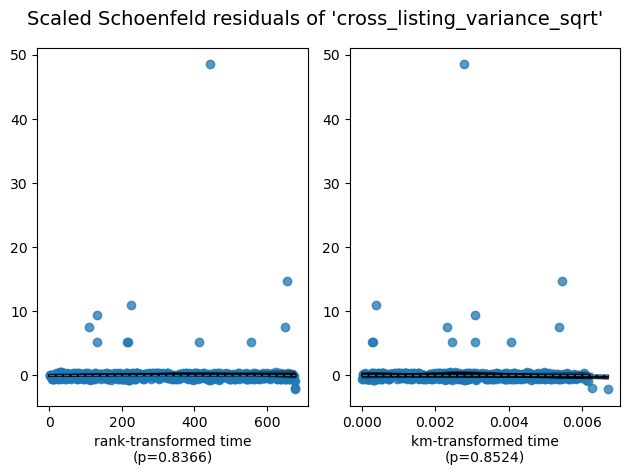

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/df_after_feature_engineering.csv")
date_cols = ['published_date','kev_published']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

df['time_to_event'] = (df['kev_published'] - df['published_date']).dt.total_seconds() / (60*60*24)
df['event'] = df['kev_present']
df.loc[df['event'] == 0, 'time_to_event'] = (pd.Timestamp.now(tz='UTC') - df.loc[df['event'] == 0, 'published_date']).dt.total_seconds() / (60*60*24)

features = ['base_score', 'repo_publication_lag', 'cross_listing_count','cross_listing_variance', 'cwe_risk_factor']
df_model = df[features + ['time_to_event', 'event']].dropna().copy()

# Apply transformations
df_model['repo_publication_lag_rank'] = df_model['repo_publication_lag'].rank()
df_model['cross_listing_variance_sqrt'] = np.sqrt(df_model['cross_listing_variance'])

# FIXED: Better categorization based on actual data distribution
print("Cross-listing count distribution:")
print(df_model['cross_listing_count'].describe())
print("\nCWE risk factor distribution:")
print(df_model['cwe_risk_factor'].describe())

# Create categories that actually have data
df_model['cross_listing_count_cat'] = pd.cut(
    df_model['cross_listing_count'], 
    bins=[0, 1, 2, float('inf')],  # Adjusted bins
    labels=['1', '2', '3']
)

df_model['cwe_risk_category'] = pd.qcut(
    df_model['cwe_risk_factor'], 
    q=4,  # Reduced to 3 categories
    labels=['low', 'medium', 'high','critical'],
    duplicates='drop'
)

# Verify the new distribution
print("\nNew strata distribution:")
strata_counts = df_model.groupby(['cross_listing_count_cat', 'cwe_risk_category'], observed=True).size()
print(strata_counts)
print(f"\nNumber of valid strata: {len(strata_counts[strata_counts > 0])}")

# Define transformed features and columns to include
transformed_features = ['base_score', 'repo_publication_lag_rank', 
                       'cross_listing_variance_sqrt']

model_cols = transformed_features + ['time_to_event', 'event', 
                                     'cross_listing_count_cat', 'cwe_risk_category']

df_final = df_model[model_cols].copy()

# Fit model with fixed stratification
cph = CoxPHFitter()
cph.fit(df_final, 
        duration_col='time_to_event', 
        event_col='event',
        strata=['cross_listing_count_cat', 'cwe_risk_category'])

print("\n" + "="*50)
print("Model Summary:")
print("="*50)
print(cph.summary)

# Check assumptions
cph.check_assumptions(df_final, 
                      columns=transformed_features, 
                      p_value_threshold=0.05, 
                      show_plots=True)

print(f"\nConcordance index: {cph.concordance_index_}")

In [2]:
df_final[df_final['event'] == 0].groupby( ['cross_listing_count_cat', 'cwe_risk_category'] ).size()

C:\Users\jvgat\AppData\Local\Temp\ipykernel_21612\3849108951.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final[df_final['event'] == 0].groupby( ['cross_listing_count_cat', 'cwe_risk_category'] ).size()


cross_listing_count_cat  cwe_risk_category
1                        low                  25842
                         medium                9964
                         high                 17315
                         critical             17632
2                        low                  21062
                         medium                7095
                         high                 14779
                         critical             13144
3                        low                      1
                         medium                   0
                         high                     1
                         critical                 2
dtype: int64

In [3]:
df_final[df_final['event'] == 1].groupby( ['cross_listing_count_cat', 'cwe_risk_category'] ).size()

C:\Users\jvgat\AppData\Local\Temp\ipykernel_21612\2390181220.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final[df_final['event'] == 1].groupby( ['cross_listing_count_cat', 'cwe_risk_category'] ).size()


cross_listing_count_cat  cwe_risk_category
1                        low                    1
                         medium                 0
                         high                   0
                         critical               1
2                        low                   13
                         medium                25
                         high                 148
                         critical             490
3                        low                    0
                         medium                 0
                         high                   0
                         critical               0
dtype: int64

## Medium Analysis

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

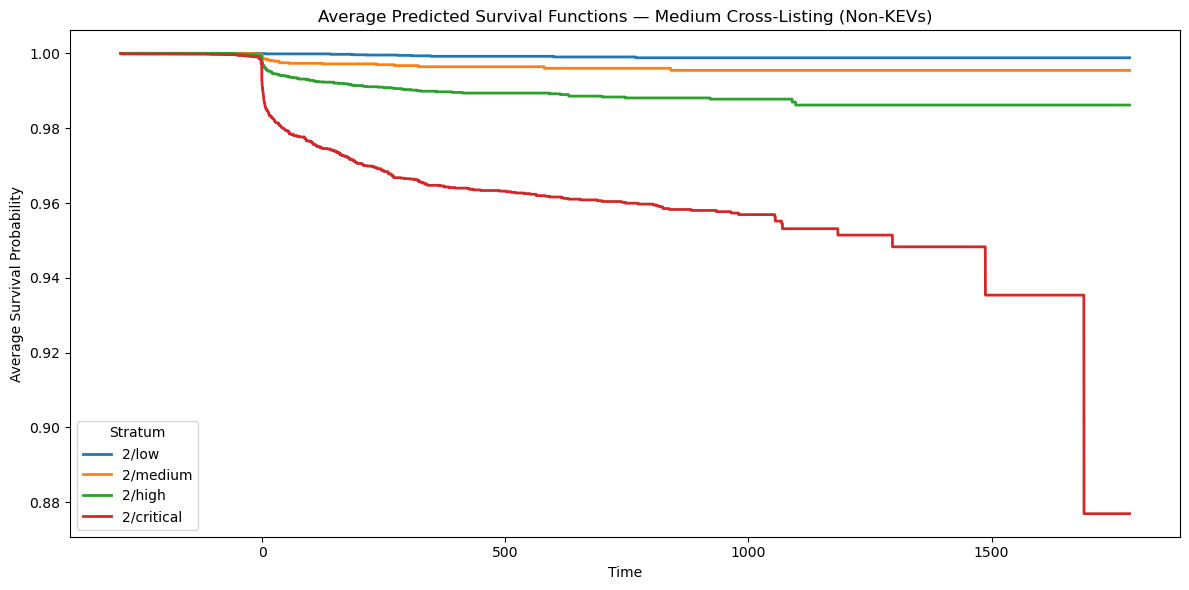

In [4]:
# ------------------------------
# 1) Keep only non-KEVs
# ------------------------------
df_nonkev = df_final[df_final['event'] == 0].copy()

# ------------------------------
# 2) Compute partial hazard for non-KEVs
# ------------------------------
df_nonkev['risk_score'] = cph.predict_partial_hazard(df_nonkev)

# ------------------------------
# 3) Merge metadata
# ------------------------------
df_nonkev = df_nonkev.merge(
    df[['vendorProject', 'product', 'vulnerabilityName','cve_id']],
    left_index=True,
    right_index=True,
    how='left'
)

# ------------------------------
# 4) Create stratum column
# ------------------------------
df_nonkev['stratum'] = (
    df_nonkev['cross_listing_count_cat'].astype(str) + '/' +
    df_nonkev['cwe_risk_category'].astype(str)
)

# ------------------------------
# 5) Focus on selected strata
# ------------------------------
strata_focus = ['2/low', '2/medium', '2/high', '2/critical']
df_focus = df_nonkev[df_nonkev['stratum'].isin(strata_focus)]

# ------------------------------
# 6) Average survival curves per stratum
# ------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

for stratum in strata_focus:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    
    if df_stratum.empty:
        continue
    
    # Predict survival functions for all rows in this stratum
    surv_funcs = cph.predict_survival_function(df_stratum)
    
    # Compute average survival at each time point
    avg_surv = surv_funcs.mean(axis=1)
    
    ax.plot(avg_surv.index, avg_surv.values, label=stratum, linewidth=2)

ax.set_title("Average Predicted Survival Functions — Medium Cross-Listing (Non-KEVs)")
ax.set_xlabel("Time")
ax.set_ylabel("Average Survival Probability")
ax.legend(title="Stratum")
plt.tight_layout()
plt.show()

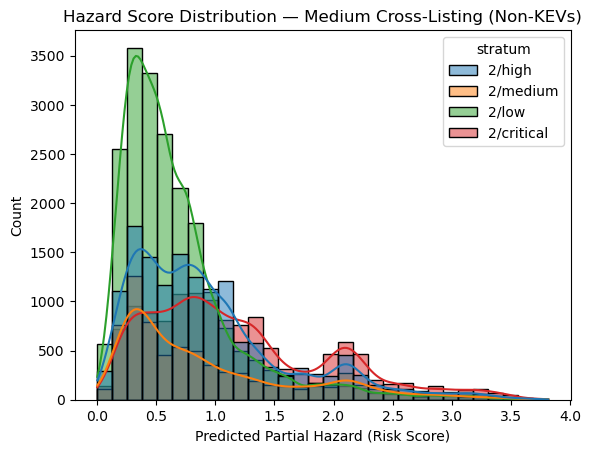

In [5]:
sns.histplot(df_focus, x='risk_score', hue='stratum', kde=True, bins=30)
plt.title("Hazard Score Distribution — Medium Cross-Listing (Non-KEVs)")
plt.xlabel("Predicted Partial Hazard (Risk Score)")
plt.ylabel("Count")
plt.show()

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

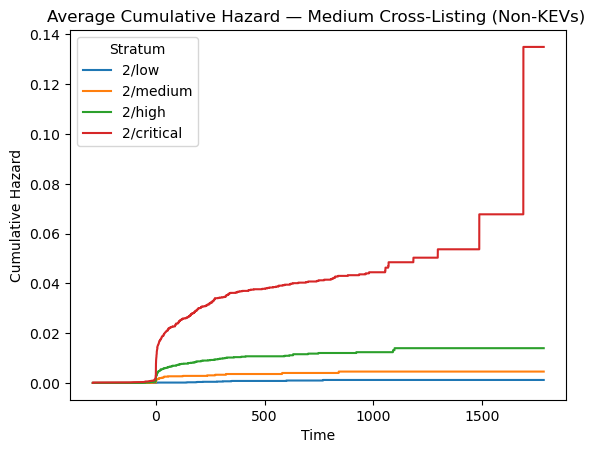

In [6]:
for stratum in strata_focus:
    df_stratum = df_focus[df_focus['stratum'] == stratum]
    cumhaz = cph.predict_cumulative_hazard(df_stratum).mean(axis=1)
    plt.plot(cumhaz.index, cumhaz.values, label=stratum)

plt.title("Average Cumulative Hazard — Medium Cross-Listing (Non-KEVs) ")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.legend(title="Stratum")
plt.show()


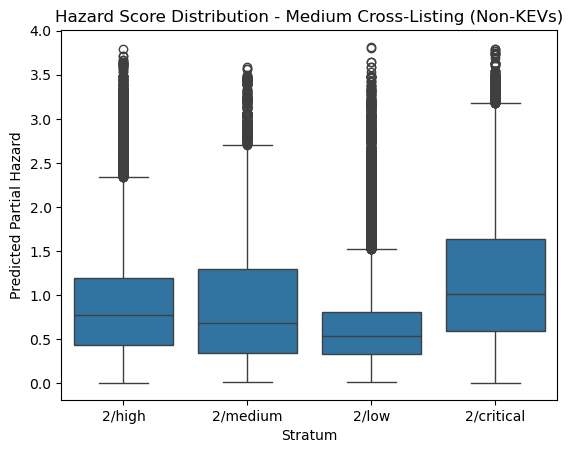

In [7]:
sns.boxplot(data=df_focus, x='stratum', y='risk_score')
plt.title("Hazard Score Distribution - Medium Cross-Listing (Non-KEVs)")
plt.xlabel("Stratum")
plt.ylabel("Predicted Partial Hazard")
plt.show()

In [9]:
# ------------------------------
# Non-KEVs in 2/critical — Predicted Survival & leveling-off time
# ------------------------------

# 1) Filter non-KEVs in stratum 2/critical
df_critical_nonkev = df_nonkev[df_nonkev['stratum'] == '2/critical'].copy()

if df_critical_nonkev.empty:
    print("No non-KEVs in the '2/critical' stratum.")
else:
    # 2) Predict survival functions for these rows
    surv_funcs = cph.predict_survival_function(df_critical_nonkev)

    # 3) Predicted survival at final observed time
    final_time = surv_funcs.index[-1]
    df_critical_nonkev['predicted_survival_probability'] = surv_funcs.loc[final_time].values

    # 4) Compute "leveling-off" time: last time the survival curve decreases
    leveling_times = []
    for idx in df_critical_nonkev.index:
        surv = surv_funcs[idx]
        decreasing_times = surv[surv.diff() < 0].index  # times where survival decreases
        leveling_times.append(decreasing_times[-1] if len(decreasing_times) > 0 else np.nan)

    df_critical_nonkev['survival plateau date'] = leveling_times

    # 5) Build table
    table = df_critical_nonkev[[
        'cve_id', 'risk_score', 'predicted_survival_probability', 'survival plateau date'
    ]].sort_values('predicted_survival_probability')

    print("\nPredicted Survival & Leveling-Off Time — Non-KEVs in 2/critical:")
    print(table.to_string(index=False))


c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):



Predicted Survival & Leveling-Off Time — Non-KEVs in 2/critical:
        cve_id  risk_score  predicted_survival_probability  survival plateau date
CVE-2025-41656    3.795751                        0.649187            1690.114423
CVE-2025-55241    3.790425                        0.649581            1690.114423
CVE-2025-34112    3.768925                        0.651173            1690.114423
 CVE-2024-6298    3.764408                        0.651507            1690.114423
CVE-2024-40628    3.749160                        0.652639            1690.114423
 CVE-2025-9118    3.741866                        0.653181            1690.114423
CVE-2024-25100    3.735008                        0.653691            1690.114423
CVE-2024-40629    3.730838                        0.654002            1690.114423
CVE-2025-32432    3.718926                        0.654889            1690.114423
CVE-2025-53577    3.695558                        0.656633            1690.114423
CVE-2022-36100    3.635810      

In [10]:
# --- Step 0: Focus on non-KEVs in critical stratum ---
df_critical_nonkev = df_focus[(df_focus['stratum'] == '2/critical') & (df_focus['event'] == 0)].copy()

# --- Step 1: Compute risk score ---
df_critical_nonkev['risk_score'] = cph.predict_partial_hazard(df_critical_nonkev)

# --- Step 2: Predict survival functions (up to 1691 days) ---
surv_funcs = cph.predict_survival_function(df_critical_nonkev)
surv_funcs = surv_funcs[surv_funcs.index <= 1691]

# --- Step 3a: Fixed survival threshold (absolute risk) ---
fixed_threshold = 0.90  # e.g., survival drops below 90%
predicted_days_fixed = []
for idx in surv_funcs.columns:
    surv_series = surv_funcs[idx]
    below = surv_series[surv_series <= fixed_threshold]
    if not below.empty:
        predicted_days_fixed.append(below.index[0])
    else:
        predicted_days_fixed.append(np.nan)
df_critical_nonkev['predicted_day_to_kev_fixed'] = predicted_days_fixed

# --- Step 3b: Data-driven survival threshold (quantile-based) ---
all_surv_values = surv_funcs.values.flatten()
quantile_threshold = np.quantile(all_surv_values, 0.05)  # 5th percentile
print("Data-driven survival threshold (5th percentile):", quantile_threshold)

predicted_days_quantile = []
for idx in surv_funcs.columns:
    surv_series = surv_funcs[idx]
    below = surv_series[surv_series <= quantile_threshold]
    if not below.empty:
        predicted_days_quantile.append(below.index[0])
    else:
        predicted_days_quantile.append(np.nan)
df_critical_nonkev['predicted_day_to_kev_quantile'] = predicted_days_quantile

# --- Step 4: Final table ---
table = df_critical_nonkev[['cve_id', 'risk_score', 
                            'predicted_day_to_kev_fixed', 
                            'predicted_day_to_kev_quantile']] \
        .sort_values('risk_score', ascending=False)

print(table.head(50).to_string(index=False))

c:\Users\jvgat\anaconda3\Lib\site-packages\lifelines\fitters\coxph_fitter.py:2339: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):


Data-driven survival threshold (5th percentile): 0.9060178608550133
        cve_id  risk_score  predicted_day_to_kev_fixed  predicted_day_to_kev_quantile
CVE-2025-41656    3.795751                  259.989467                     225.572833
CVE-2025-55241    3.790425                  264.156088                     225.572833
CVE-2025-34112    3.768925                  264.197779                     231.364431
 CVE-2024-6298    3.764408                  266.322773                     231.364431
CVE-2024-40628    3.749160                  267.072772                     236.322756
 CVE-2025-9118    3.741866                  267.072772                     236.322756
CVE-2024-25100    3.735008                  267.489457                     236.405712
CVE-2024-40629    3.730838                  267.489457                     236.405712
CVE-2025-32432    3.718926                  270.114488                     236.989484
CVE-2025-53577    3.695558                  270.239000                  

In [11]:
import plotly.express as px

# Prepare a combined dataframe with both threshold predictions
df_plot = df_critical_nonkev.copy()
df_plot['predicted_day_to_kev_fixed'] = df_plot['predicted_day_to_kev_fixed']
df_plot['predicted_day_to_kev_quantile'] = df_plot['predicted_day_to_kev_quantile']

# Interactive scatter plot
fig = px.scatter(
    df_plot,
    x='risk_score',
    y='predicted_day_to_kev_fixed',
    color='risk_score',
    color_continuous_scale='Reds',
    hover_data={
        'cve_id': True,
        'risk_score': True,
        'predicted_day_to_kev_fixed': True,
        'predicted_day_to_kev_quantile': True
    },
    labels={
        'risk_score': 'Predicted Risk Score',
        'predicted_day_to_kev_fixed': 'Predicted Days to KEV (Fixed Threshold)'
    },
    title='Predicted Days to KEV vs Risk Score — Critical Stratum Non-KEVs',
    opacity=0.7
)

# Add quantile threshold lines (optional)
quantiles = [0.5, 0.75, 0.9]
for q in quantiles:
    q_value = df_plot['risk_score'].quantile(q)
    fig.add_vline(x=q_value, line=dict(color='gray', dash='dash'), annotation_text=f"{int(q*100)}%", 
                  annotation_position="top right")

# Highlight high-risk region (>90th percentile)
high_risk_threshold = df_plot['risk_score'].quantile(0.9)
fig.add_vrect(x0=high_risk_threshold, x1=df_plot['risk_score'].max(), 
              fillcolor="yellow", opacity=0.2, layer="below", line_width=0, 
              annotation_text="High-risk region (>90th percentile)", annotation_position="top left")

fig.update_layout(coloraxis_colorbar=dict(title="Risk Score"))
fig.show()

# Interpretations

## predicted_day_to_kev_fixed
### the day the model predicts this CVE has reached a 10% risk of becoming a KEV

## predicted_day_to_kev_quantile
### the day the model predicts this CVE reaches a risk level that is among the most extreme 5% of predicted risks